# COGS 189 Final Project

WI25

**Name**: Danny Rivera

**PID:** A16906333

**Group Name**: Anxiety Classification

**Link to Original Dataset and Paper**: [Identification of Major Psychiatric Disorders From Resting-State Electroencephalography Using a Machine Learning Approach](https://www.frontiersin.org/journals/psychiatry/articles/10.3389/fpsyt.2021.707581/full)
*Park, S. M. (2021, August 16).*

#### Goals
1. Use different ML techniques to differentiate anxiety patient disorders from control patients using binary classification (most EEG studies to classify disorders involve classifying schizophrenia, Alzheimer's)
2. Determine which model(s) works best for classifying which disorders

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# read in data
df = pd.read_csv("EEG.machinelearing_data_BRMH.csv")

# Dataset

#### About the Dataset
- **What:** Resting state EEG via Compumedics Neuroscan, CSV file
    - 19 channels based on 10-20 system
    - Fs = 128
    - Recorded over 5 minutes
- **When:** Jan 2011 - Dec 2018
- **Where:** Seoul Metropolitan Government-Seoul National University (SMG-SNU) Boramae Medical Center, Seoul, South Korea
- **Who:** Multiple researchers at SNU and Ewha Womans University (both in Seoul)
    - Departments of Psychiatry and Behavioral Science, Statistics, Institute of Human Behavioral Medicine

The dataset originally has 945 rows, or recordings, and 1149 columns.

Columns vary from holding patient ID information (`no.`), information about patient demographic (`sex`, `age`, etc), name of the patient's condition (`main.disorder`, `specific.disorder`), or EEG attributes (`AB.A.delta.a.FP1`, etc).

In [3]:
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (945, 1149)


,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


## Anxiety Subset

In [4]:
df['main.disorder'].value_counts()

main.disorder
Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: count, dtype: int64

There are a lot of different categories of disorders originally included, such as patients with schizophrenia, Alzheimer's, and various mood disorders. My project will only focus on the patients with anxiety-related disorders.

In [5]:
df[df['main.disorder'] == 'Anxiety disorder']['specific.disorder'].value_counts()

specific.disorder
Panic disorder             59
Social anxiety disorder    48
Name: count, dtype: int64

There are two types of specific disorders found in the anxiety category: **Panic disorder** and **Social Anxiety** disorder.

Next, I will reduce the dataset to only include either control patients or patients with these two specific disorders.

In [6]:
# reducing dataset to either HC or anxiety patients
df = df[(df['main.disorder'] == 'Anxiety disorder') | (df['main.disorder'] == 'Healthy control')]

print("Shape of Dataset After Filtering:", df.shape)
df.head()

Shape of Dataset After Filtering: (202, 1149)


,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
113,114,F,34.16,2018.6.29,18.0,119.0,Healthy control,Healthy control,72.431249,69.386059,...,78.997160,67.622353,70.376986,66.281673,82.552243,57.823441,69.899527,52.622502,73.606786,64.037927
114,115,F,42.35,2018.6.29,16.0,110.0,Healthy control,Healthy control,19.579138,19.703305,...,67.123295,38.645146,47.996626,48.602407,66.139329,40.072587,62.466377,27.778563,59.736363,47.235652
115,116,F,35.16,2018.6.30,16.0,122.0,Healthy control,Healthy control,17.916294,22.911557,...,92.844007,81.673530,78.755278,83.905221,87.903450,75.363909,85.757201,73.195374,85.954023,82.878713
116,117,F,25.65,2018.7.2,18.0,118.0,Healthy control,Healthy control,20.081892,17.928614,...,99.447826,99.424714,44.181841,61.683927,99.513428,43.007308,62.525177,42.766646,62.843978,39.895496
117,118,F,18.89,2018.7.3,12.0,108.0,Healthy control,Healthy control,18.429434,26.156602,...,79.946089,72.771884,64.189258,69.407868,61.586105,45.679693,51.780683,61.221166,75.595992,69.627654


This greatly reduces our dataset, and there is now only 202 rows. Let's see how many patients there are for each condition:

In [7]:
print(f"Number of Controls: {len(df[df['main.disorder'] == 'Healthy control'])}")
print(f"Number of Panic Disorder patients: {len(df[df['specific.disorder'] == 'Panic disorder'])}")
print(f"Number of Social Anxiety Disorder patients: {len(df[df['specific.disorder'] == 'Social anxiety disorder'])}")

Number of Controls: 95
Number of Panic Disorder patients: 59
Number of Social Anxiety Disorder patients: 48


As shown, there is a disproportionate amount of control patients compared to the two specific anxiety groups. This means the classes are unbalanced, which will affect how I conduct classification. Unbalanced classes mean we cannot use classification accuracy as a measurement, so I will use F1 scores instead.

## Demographics

After reducing the dataframe to just anxiety and control patients, I thought it might be interesting to look at some demographics of our data before deleting these columns for algorithm processing.

### Gender

In [8]:
gender = df['sex'].value_counts()

Male Subjects: 139
Female Subjects: 63


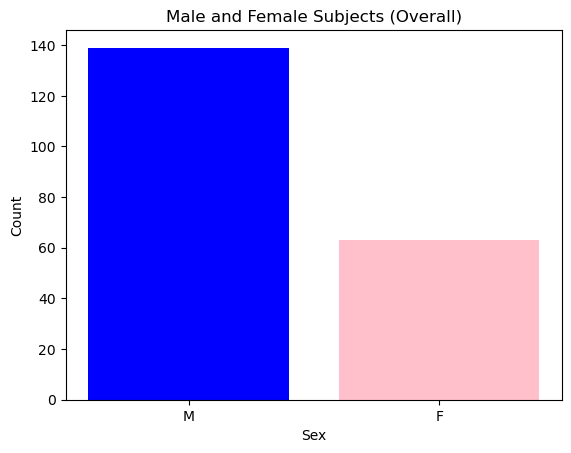

In [9]:
print(f"Male Subjects: {gender.iloc[0]}")
print(f"Female Subjects: {gender.iloc[1]}")

plt.bar(gender.index, gender.values, color=['blue', 'pink'])
plt.title("Male and Female Subjects (Overall)")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show();

### Age

In [10]:
print(f"Average Patient Age: {round(df['age'].mean(), 2)}")

Average Patient Age: 27.47


## Overview of Columns

Columns can be grouped by three main categories:
1. PSD value of the specified band for each electrode (i.e `'AB.A.delta.a.FP1'`)
2. Coherence value between two electrodes across a certain band (i.e `'COH.F.gamma.r.01.s.02'`)
3. "Other": Columns with demographic information (i.e `age`) or other irrelevant columns

For now, I will focus on the columns of the first category, PSD values for band values of electrodes. However, it would be really interesting to incorporate the coherence columns and observe how my classification metrics change with them.

In [11]:
# rename columns
psd_cols = []
coh_cols = []
other = []

def group_columns():
    
    # separate columns
    for i in df.columns:
        if 'AB' in i:
            psd_cols.append(i)
        elif 'COH' in i:
            coh_cols.append(i)
        else:
            other.append(i)

group_columns()

# add 'label' as one of the column names, for classification
psd_cols.append('label')

In [12]:
# label data based on condition
# 0 = Healthy control
# 1 = Panic disorder
# 2 = Social anxiety
df['label'] = df['specific.disorder'].replace({'Healthy control': 0, 'Panic disorder': 1, 'Social anxiety disorder':2})

/tmp/ipykernel_8038/3532758948.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['specific.disorder'].replace({'Healthy control': 0, 'Panic disorder': 1, 'Social anxiety disorder':2})


In [13]:
# drop irrelevant columns, restricting to only PSD value columns and 'label' column
df = df[psd_cols]

In [14]:
df

,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,...,AB.F.gamma.k.C4,AB.F.gamma.l.T4,AB.F.gamma.m.T5,AB.F.gamma.n.P3,AB.F.gamma.o.Pz,AB.F.gamma.p.P4,AB.F.gamma.q.T6,AB.F.gamma.r.O1,AB.F.gamma.s.O2,label
113,72.431249,69.386059,62.775437,69.193931,69.447900,69.042085,57.324333,41.658465,55.851042,56.265661,...,2.629897,1.921199,2.833677,3.291747,2.824944,2.820016,2.248725,2.982932,2.940030,0
114,19.579138,19.703305,23.000027,31.034078,22.461115,23.616729,50.770251,14.458573,13.843582,19.761720,...,3.053290,2.505505,5.045257,4.101235,5.778042,3.676781,5.580233,6.530776,6.796860,0
115,17.916294,22.911557,19.951421,16.835759,16.792161,16.887329,27.237218,10.324034,16.298826,19.518705,...,4.408061,4.432309,3.839380,4.121491,3.959794,4.245507,4.349864,4.078656,3.722995,0
116,20.081892,17.928614,15.977752,18.119963,17.029861,13.545934,11.612536,13.578299,13.790407,14.739175,...,0.938444,0.652126,0.874891,0.800209,0.911272,0.823876,0.676607,0.654119,0.682812,0
117,18.429434,26.156602,15.751990,21.654509,26.128217,26.002065,16.649180,7.972443,24.789548,21.259534,...,2.729161,2.882060,2.163485,2.393303,2.455410,2.517420,2.242771,1.933288,2.269774,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,7.520642,17.636528,20.220791,...,1.763397,1.285942,2.437923,2.130979,1.727413,1.710518,2.574734,2.533354,5.596057,0
941,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,13.178851,12.687296,20.257619,...,2.685138,2.648595,2.559590,3.054965,3.163359,3.247100,2.646515,3.385173,3.085049,0
942,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,11.368466,21.799254,36.083181,...,2.434620,1.501337,0.840513,1.733498,1.610465,1.644675,1.216763,1.614421,1.164097,0
943,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,13.438102,17.442777,18.859586,...,1.678465,3.655796,1.429330,3.151128,1.630643,1.888551,1.447402,1.819110,1.302056,0


# ML Classification

I will now use three types of supervised machine learning algorithms to attempt to classify the data: Logistic regression, Random Forest, and Support Vector Machines (SVM). For each algorithm, I will write a function to create one model that can be used with either control and panic disorder data or control and social anxiety data. Then, I will use `classification_report` to print the metrics used to evaluate the performance of each model.

### Logistic Regression

In [15]:
def logistic_regression(category):
    '''Use a Logistic Regression model to compare healthy control patients to one of the two anxiety disorders.
    1 = Panic Disorder patients, 2 = Social Anxiety patients.'''
    df_category = df[df['label'].isin([0, category])]
    X = df_category.drop(columns=['label'])
    X = np.log(X)
    y = df_category['label']

    # split data to train and test
    # 80% training data and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

    # normalize data
    scaling = MinMaxScaler()
    X_train = scaling.fit_transform(X=X_train)
    X_test = scaling.transform(X=X_test)

    # logistic regression model
    LR_model = LogisticRegression(class_weight='balanced')
    LR_model.fit(X_train, y_train)

    # make predictions
    y_pred = LR_model.predict(X_test)

    # print classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))

#### Panic vs. Healthy Patients (Logistic Regression)

In [16]:
print(logistic_regression(1))

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.68      0.76        19
           1       0.62      0.83      0.71        12

    accuracy                           0.74        31
   macro avg       0.75      0.76      0.74        31
weighted avg       0.77      0.74      0.75        31

None


#### Social Anxiety vs. Healthy Patients (Logistic Regression)

In [17]:
print(logistic_regression(2))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.47      0.60        19
           2       0.44      0.80      0.57        10

    accuracy                           0.59        29
   macro avg       0.63      0.64      0.59        29
weighted avg       0.69      0.59      0.59        29

None


### Random Forest

In [18]:
def random_forest(category):
    '''Use a Random Forest model to compare healthy control patients to one of the two anxiety disorders.
    1 = Panic Disorder patients, 2 = Social Anxiety patients.'''
    df_category = df[df['label'].isin([0, category])]
    X = df_category.drop(columns=['label'])
    X = np.log(X)
    y = df_category['label']

    # split data to train and test
    # 80% training data and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

    # normalize data
    scaling = MinMaxScaler()
    X_train = scaling.fit_transform(X=X_train)
    X_test = scaling.transform(X=X_test)

    # random forest model
    RF_model = RandomForestClassifier(random_state=15)
    RF_model.fit(X_train, y_train)

    # make predictions
    y_pred = RF_model.predict(X_test)

    # print classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))

#### Panic Disorder vs. Control (Random Forest)

In [19]:
print(random_forest(1))

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67        19
           1       0.45      0.42      0.43        12

    accuracy                           0.58        31
   macro avg       0.55      0.55      0.55        31
weighted avg       0.57      0.58      0.58        31

None


#### Social Anxiety Disorder vs. Control (Random Forest)

In [20]:
print(random_forest(2))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77        19
           2       0.56      0.50      0.53        10

    accuracy                           0.69        29
   macro avg       0.65      0.64      0.65        29
weighted avg       0.68      0.69      0.69        29

None


### Support Vector Machine (SVM)

In [21]:
def SVM(category):
    '''Use a SVM model to compare healthy control patients to one of the two anxiety disorders.
    1 = Panic Disorder patients, 2 = Social Anxiety patients.'''
    df_category = df[df['label'].isin([0, category])]
    X = df_category.drop(columns=['label'])
    X = np.log(X)
    y = df_category['label']

    # split data to train and test
    # 80% training data and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

    # normalize data
    scaling = MinMaxScaler()
    X_train = scaling.fit_transform(X=X_train)
    X_test = scaling.transform(X=X_test)

    # SVM model
    SVM_model = SVC(kernel='linear', random_state=15)
    SVM_model.fit(X_train, y_train)

    # make predictions
    y_pred = SVM_model.predict(X_test)

    # print classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))

#### Panic Disorder vs. Control (SVM)

In [22]:
print(SVM(1))

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80        19
           1       0.70      0.58      0.64        12

    accuracy                           0.74        31
   macro avg       0.73      0.71      0.72        31
weighted avg       0.74      0.74      0.74        31

None


#### Social Anxiety vs. Control (SVM)

In [23]:
print(SVM(2))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81        19
           2       0.64      0.70      0.67        10

    accuracy                           0.76        29
   macro avg       0.73      0.74      0.74        29
weighted avg       0.77      0.76      0.76        29

None


# Results

Overall, the Logistic regression and SVM models show the best performance in classifying panic disorder patients or social anxiety patients against control patients. F1-scores reported using the first trial of logistic regression were 0.76 for controls and 0.71 for panic disorder patients, and the second trial reported F1 scores of 0.60 for controls and 0.57 for social anxiety patients. SVM showed similar results, with F1-scores of 0.8 and 0.64 for control and panic disorder patients, respectively, and then 0.81 and 0.67 for control and social anxiety patients, again, respectively.

However, there are significant limitations in the analysis. Due to the small size of the dataset, these results cannot be seen as fully accurate. Cross-validation and hyperparameter tuning could have been further done to improve the performance of the models and ensure reliability. Overall, my results reported lower performance than the original paper in which the dataset was sourced, although this is to be expected.